# Model validation water levels

Note: this notebook requires the model output data

In [29]:
import mikeio
import modelskill as ms
import matplotlib.pyplot as plt 
import helper as h

In [30]:
ms.options.metrics.list = ["rmse", "mae", "cc", "si", "r2"]

Instead of reading the entire dfsu (`Area.dfsu`), we can simply load the outputted points (dfs0) since they correspond to the locations we have observations from.

In [31]:
mr_fldr = "../output/"    
mr_fldr = "../output_sample/"     # use this if you have not downloaded the full data from Zenodo yet
save_png = False if "sample" in mr_fldr else True
fig_fldr = "../figures/" 


Model results data are stored in a dfs0 file. We can use [MIKE IO](https://dhi.github.io/mikeio) read the data to a MIKE IO Dataset.

Note: The first two spin-up days are excluded.

In [32]:
ds = mikeio.read(f"{mr_fldr}Points.dfs0", items="*Surf*", time = slice("2022-01-03", None))
ds.items

[NWA: Surface elevation <Surface Elevation> (meter),
 IJVA: Surface elevation <Surface Elevation> (meter),
 DDW1A: Surface elevation <Surface Elevation> (meter),
 F3platform: Surface elevation <Surface Elevation> (meter),
 K13a: Surface elevation <Surface Elevation> (meter),
 Europlatform: Surface elevation <Surface Elevation> (meter),
 J61: Surface elevation <Surface Elevation> (meter)]

## Compare to water level station observations

The [ModelSkill package](https://dhi.github.io/modelskill/) can be used to compare model results with observations.

In [33]:
wllist = h.get_wl_point_obs()

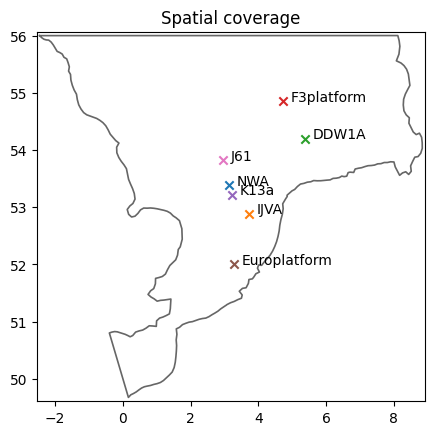

In [34]:
msh = mikeio.open("../input/Mesh_8000_elems_HD_v2.mesh")
ms.plotting.spatial_overview(wllist, mod=msh);

Match the right model result timeseries and observation. Also, remove the bias (different vertical datum).

In [35]:
cmps = []
for o in wllist:
    mr = ms.PointModelResult(ds[o.name+": Surface elevation"], name="MIKE21")
    try:
        cmp = ms.match(obs=o, mod=mr)
    except Exception as e:
        print(e)
    cmps.append(cmp.remove_bias())
cc = ms.ComparerCollection(cmps)

No data left after trimming to 2022-12-31 23:59:59 - 2023-01-08 00:00:01


## Skill table

In [36]:
cc.skill().round(3)

,n,rmse,mae,cc,si,r2
observation,,,,,,
NWA,154,0.165,0.145,0.943,0.398,0.886
IJVA,337,0.143,0.107,0.907,0.527,0.817
F3platform,337,0.079,0.063,0.940,0.409,0.882
K13a,337,0.143,0.111,0.943,0.413,0.883
Europlatform,337,0.156,0.127,0.964,0.322,0.925
J61,337,0.140,0.110,0.966,0.327,0.922


We can see from the skill table that the model has an RMSE of 6.5-9.7 cm. 

## Example timeseries

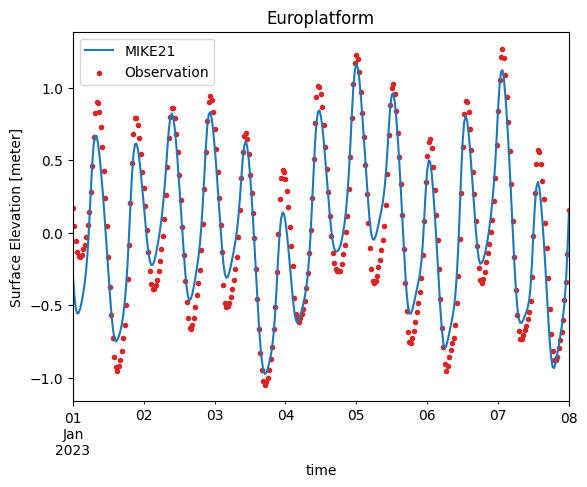

In [40]:
t_plot = slice("2023-12-01","2023-12-31") if "2023-12-01" in ds.time else slice(None, None)
cc["Europlatform"].sel(time=t_plot).plot.timeseries();

## Scatter plots

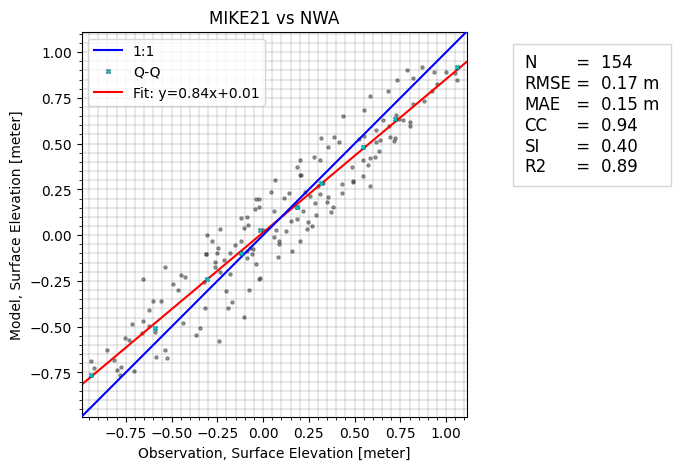

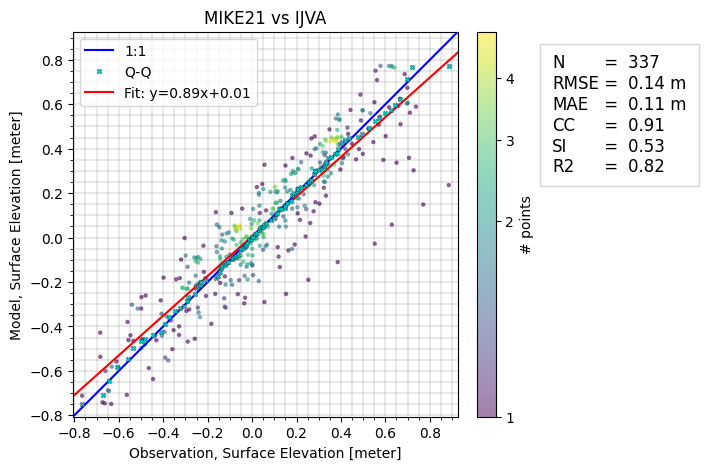

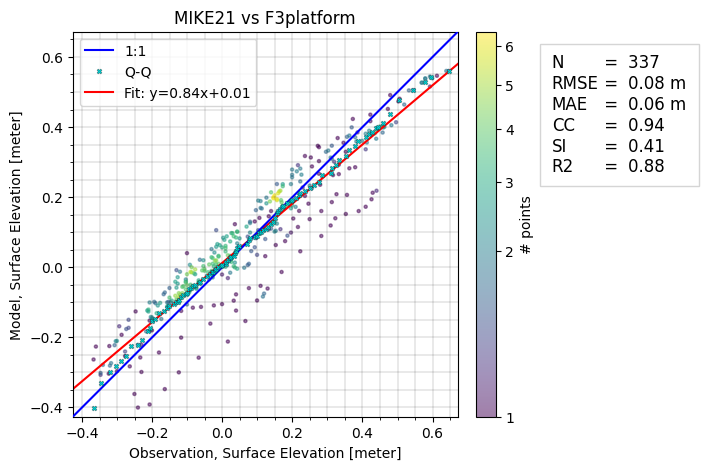

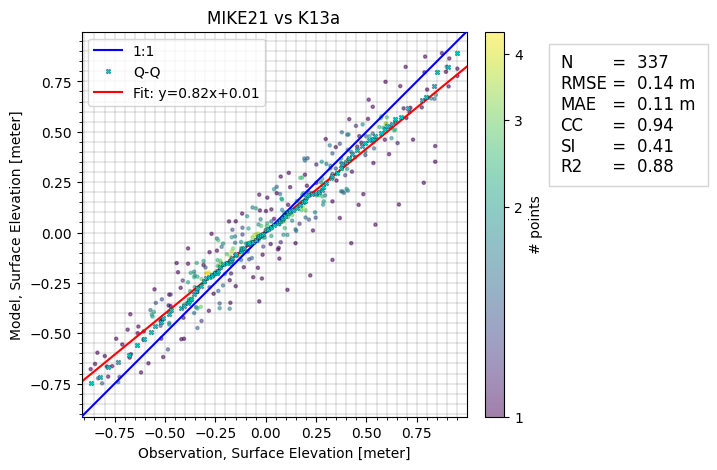

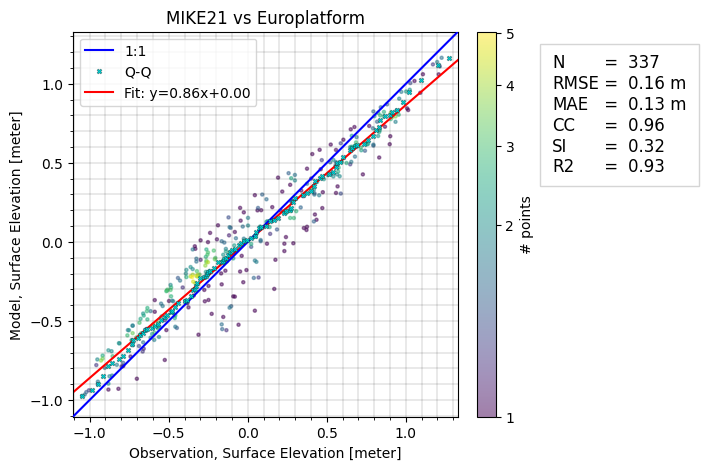

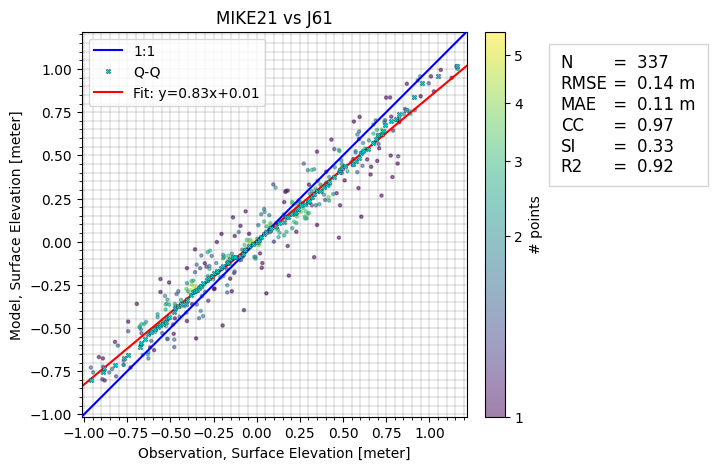

In [41]:
n_points_shown = 20000
for cmp in cc:
    cmp.plot.scatter(skill_table=True, show_points=n_points_shown, figsize=(6,5), bins=40);
    if save_png:
        plt.savefig(f"{fig_fldr}modelskill_comparison_{cmp.name}.png", bbox_inches='tight');